## Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import plotly.plotly as py
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
%matplotlib inline
plt.style.use('ggplot')
init_notebook_mode(connected=True)
cf.go_offline()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Load files

In [2]:
electric = pd.read_csv("Full Eletric Interval 042016.csv")

In [3]:
electric['Datetime'] = pd.to_datetime(electric['Date'] + ' ' + electric['Start Time'])

In [4]:
propertyCode = pd.read_excel("SIMS_Property_List_4-6-2016_Revised.xlsx")

In [5]:
weather = pd.read_csv('weather_prepared_final.csv')

In [6]:
weather.DATE = pd.to_datetime(weather.DATE)

### List of codes

In [7]:
codelist = [b[0] for b in electric['Meter'].str.split()]

In [8]:
codes = pd.Series(codelist)

### Usage by day

In [9]:
electric_date_full = electric
electric_date_full.Datetime = electric_date_full.Datetime.dt.date

In [10]:
electric_day = electric_date_full.drop('Temperature', 1).groupby(by=['Meter', 'Datetime']).sum()

### Temperature

In [11]:
temperature = weather.drop(['HUMIDITY', 'LON', 'LAT', 'STATION'], 1).iloc[1::4, :]

### Daily average temperature

In [12]:
daily_temperature = temperature
daily_temperature.DATE = temperature.DATE.dt.date
daily_temperature = daily_temperature.groupby(by='DATE').mean()

### Humidity

In [13]:
humidity = weather.drop(['TEMPERATURE', 'LON', 'LAT', 'STATION'], 1).iloc[1::4, :]

### Daily average humidity

In [14]:
daily_humidity = humidity
daily_humidity.DATE = humidity.DATE.dt.date
daily_humidity = daily_humidity.groupby(by='DATE').mean()

## Functions

In [15]:
def normal_usage(meter, date, temperature, humidity):
    weekend = pd.to_datetime(date).weekday() in [5,6]
    meter_usage = electric_day.ix[meter]
    return meter_usage[(abs(pd.to_datetime(date).dayofyear - pd.to_datetime(meter_usage.index).dayofyear) < 20) & (daily_temperature.ix[meter_usage.index]['TEMPERATURE'] > temperature - 4) & (daily_temperature.ix[meter_usage.index] < temperature + 4).squeeze() & (daily_humidity.ix[meter_usage.index]['HUMIDITY'] > humidity - 12) & (daily_humidity.ix[meter_usage.index] < humidity + 12).squeeze() & (pd.to_datetime(meter_usage.index).weekday.isin([5,6]) == weekend)]['Usage'].mean()

In [16]:
def percent_difference(meter, date, temperature, humidity, usage):
    normal = normal_usage(meter, date, temperature, humidity)
    if usage > 100:
        if normal == 0:
            normal = 1
        return 100 * (usage - normal) / normal
    return float('nan')

In [17]:
def percent_diff_lst(meter):
    dates = pd.to_datetime(electric_day.ix[meter].index)
    start = pd.to_datetime('2015-01-01')
    end = pd.to_datetime('2016-04-10')
    electric_day_temp = electric_day.ix[meter][(dates >= start) & (dates <= end)]
    diff_lst = []
    date_lst = []
    for day in electric_day_temp.index:
        temperature = daily_temperature.ix[pd.to_datetime(day).date()]
        humidity = daily_humidity.ix[pd.to_datetime(day).date()]
        usage = electric_day_temp.ix[pd.to_datetime(day).date()]
        diff = percent_difference(meter, day.strftime('%Y-%m-%d'), float(temperature), float(humidity), float(usage))
        diff_lst.append(diff)
        date_lst.append(day)
    return pd.DataFrame(diff_lst, date_lst, ['Percent Difference'])

In [18]:
def anomalies(meter):
    diff = percent_diff_lst(meter)
    return diff[diff['Percent Difference'] > 12]

In [19]:
def large_anomalies(meter):
    diff = percent_diff_lst(meter)
    return diff[diff['Percent Difference'] > 50]

In [20]:
def anomaly_groups(meter):
    anom = anomalies(meter)
    dates = []
    for i in anom.index:
        for j in anom.index:
            distance = abs(pd.to_datetime(i).dayofyear - pd.to_datetime(j).dayofyear)
            if (distance < 14) & (distance > 0):
                dates.append(i)
    unique_dates = pd.Series(dates).unique()
    return unique_dates

In [21]:
def normal_usage_lst(meter):
    dates = pd.to_datetime(electric_day.ix[meter].index)
    start = pd.to_datetime('2015-01-01')
    end = pd.to_datetime('2016-04-10')
    electric_day_temp = electric_day.ix[meter][(dates >= start) & (dates <= end)]
    norm_lst = []
    date_lst = []
    for day in electric_day_temp.index:
        temperature = daily_temperature.ix[pd.to_datetime(day).date()]
        humidity = daily_humidity.ix[pd.to_datetime(day).date()]
        usage = electric_day_temp.ix[pd.to_datetime(day).date()]
        norm = normal_usage(meter, day.strftime('%Y-%m-%d'), float(temperature), float(humidity))
        norm_lst.append(norm)
        date_lst.append(day)
    return pd.DataFrame(norm_lst, date_lst, ['Normal Usage'])

### Total

In [22]:
electric_total = electric.groupby(by = 'Date').sum()

In [23]:
def normal_usage_total(date, temperature, humidity):
    weekend = pd.to_datetime(date).weekday() in [5,6]
    dates = pd.to_datetime(electric_total.index)
    return electric_total[(abs(pd.to_datetime(date).dayofyear - dates.dayofyear) < 20) & (daily_humidity.ix[dates]['HUMIDITY'] > humidity - 10) & (daily_humidity.ix[dates] < humidity + 10).squeeze() & (daily_temperature.ix[dates]['TEMPERATURE'] > temperature - 4) & (daily_temperature.ix[dates] < temperature + 4).squeeze() & (dates.weekday.isin([5,6]) == weekend)]['Usage'].mean()

In [24]:
def percent_difference_total(date, temperature, humidity, usage):
    normal = normal_usage_total(date, temperature, humidity)
    return 100 * (usage - normal) / normal

In [25]:
def percent_diff_lst_total():
    dates = pd.to_datetime(electric_total.index)
    start = pd.to_datetime('2015-01-01')
    end = pd.to_datetime('2016-04-10')
    electric_day_temp = electric_total[(dates >= start) & (dates <= end)]
    diff_lst = []
    date_lst = []
    for day in electric_day_temp.index:
        temperature = daily_temperature.ix[pd.to_datetime(day).date()]
        humidity = daily_humidity.ix[pd.to_datetime(day).date()]
        usage = electric_day_temp.ix[day]
        diff = percent_difference_total(day, float(temperature), float(humidity), float(usage[0]))
        diff_lst.append(diff)
        date_lst.append(day)
    return pd.DataFrame(diff_lst, date_lst, ['Percent Difference'])

In [26]:
def anomalies_total():
    diff = percent_diff_lst_total()
    return diff[diff['Percent Difference'] > 6]

## Plotting Functions

In [27]:
def single_building_meters_overlay(code, start=pd.to_datetime('2014-04-11 23:30:00'), end=pd.to_datetime('2016-04-10 23:30:00')):
    meterdf = electric[codes.isin([code])].groupby(by=['Meter', 'Datetime']).mean().unstack('Meter')
    meterdf = meterdf[(meterdf.index >= start) & (meterdf.index <= end)]
    meterdf.plot(y='Usage', figsize=(20,10))
    plt.ylabel('Usage (kWh)')
    plt.title(code)

In [28]:
def compare_normal_usage(meter):
    normal = normal_usage_lst(meter)
    actual = electric_day.ix[meter]
    fig = {
        'data': [
            {'x': normal.index, 'y': normal['Normal Usage'], 'mode': 'markers', 'name': 'Average Usage'},
            {'x': actual.index, 'y': actual.Usage, 'mode': 'markers', 'name': 'Actual Usage'}
        ],
        'layout': {
            'xaxis': {'title': 'Date'},
            'yaxis': {'title': 'Usage'}
        }
    }
    iplot(fig)

# Plots and buildings

## Total

In [128]:
percent_diff_lst_total().iplot()

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [132]:
anomalies_total()

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



Percent Difference
2015-06-10            6.319911
2015-12-08            7.904913

In [133]:
all_anomalies = pd.DataFrame()
for meter in electric_day.index.levels[0]:
    all_anomalies = pd.concat([all_anomalies, anomalies(meter)])

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [136]:
all_anomalies.groupby(all_anomalies.index).count().iplot(kind='bar')

## Temperature

In [142]:
daily_anomalies = all_anomalies.groupby(all_anomalies.index).count()
fig = {
        'data': [
            {'x': daily_temperature.index, 'y': daily_temperature['TEMPERATURE'], 'mode': 'markers', 'name': 'Temperature'},
            {'x': daily_anomalies.index, 'y': daily_anomalies['Percent Difference'], 'mode': 'markers', 'name': 'Anomalies', 'yaxis': 'y2'}
        ],
        'layout': {
            'xaxis': {'title': 'Date'},
            'yaxis': {'title': 'Temperature'},
            'yaxis2': {'title': 'Anomalies', 'overlaying': 'y', 'side': 'right'}
        }
    }
iplot(fig)

In [37]:
daily_temperature.iplot()

## Humidity

In [144]:
daily_anomalies = all_anomalies.groupby(all_anomalies.index).count()
fig = {
        'data': [
            {'x': daily_humidity.index, 'y': daily_humidity['HUMIDITY'], 'mode': 'markers', 'name': 'Humidity'},
            {'x': daily_anomalies.index, 'y': daily_anomalies['Percent Difference'], 'mode': 'markers', 'name': 'Anomalies', 'yaxis': 'y2'}
        ],
        'layout': {
            'xaxis': {'title': 'Date'},
            'yaxis': {'title': 'Humidity'},
            'yaxis2': {'title': 'Anomalies', 'overlaying': 'y', 'side': 'right'}
        }
    }
iplot(fig)

In [140]:
daily_humidity.iplot()

## Meter names

In [31]:
electric.Meter.unique()

array(['A06 Crerar Library (B1)', 'F02 Steam Plant (B1)',
       'G02 Capin Hall (B1)', 'D36 Social Science Building (B1)',
       'H01 Computers 1155 Building (B1)', 'A11 Kovler Laboratories (B1)',
       'A08 Hinds Laboratories (R1)', 'A84 American School (B1)',
       'A62 Cummings Life Sciences (B1)', 'A13 Bookstore (B1)',
       'H02 Law School (B1)', 'A22 Carlson Animal Research (B4)',
       'F02 Steam Plant (B2)', 'C02 Crown Field House (B1)',
       'E21 Breckinridge House (B1)', 'D14 Center Gender Studies (B1)',
       'L07 5482 S. Greenwood Ave (R1)', 'D25 Walker Museum (R1)',
       'D25 Walker Museum (R2)', 'I13 Woodlawn Social Service (B1)',
       'D53 Pick Hall (R1)', 'N11 ATS (B1)',
       'B34 Stagg Field Building (B1)', 'D16 Eckhart/Ryerson (B1)',
       'D16 Eckhart/Ryerson (B2)', 'C31 54th & Ellis Parking (B1)',
       'C31 54th & Ellis Parking (B2)', 'D20 Levi Hall (B1)',
       'I10 6022-24 S. Drexel (B3)', 'B36 BSLC (B1)',
       'A50 MRS Building (CLSC) (B1)', 

## Law School

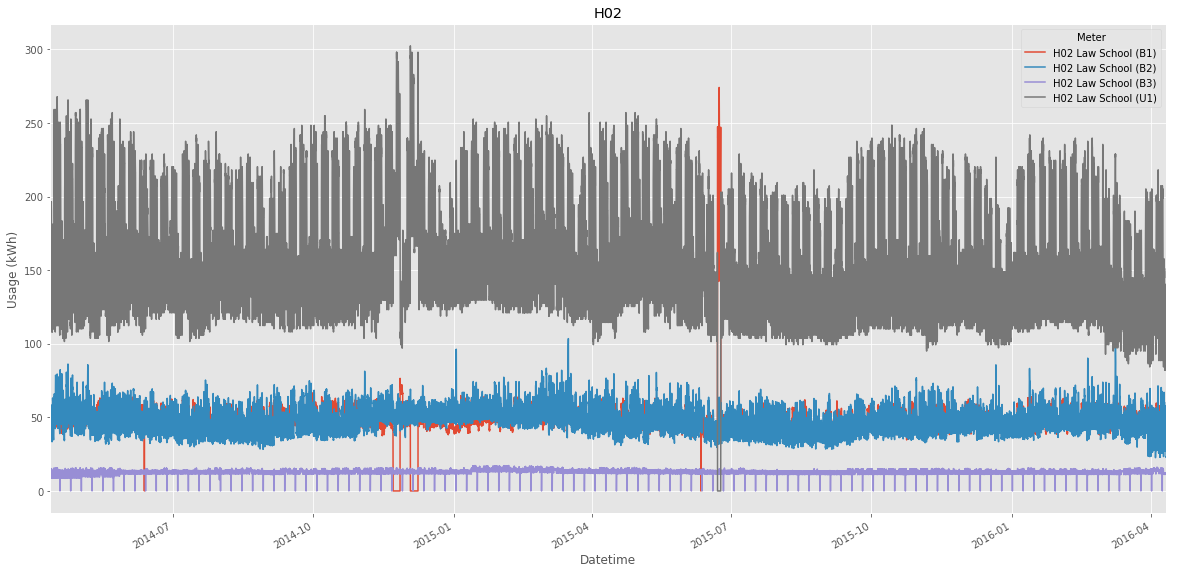

In [91]:
single_building_meters_overlay('H02')

In [124]:
compare_normal_usage('H02 Law School (U1)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [125]:
anomalies('H02 Law School (U1)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



Percent Difference
2015-03-07           16.533709
2015-03-09           12.628448
2015-03-10           12.550085
2015-03-11           14.157514
2015-03-12           13.524896
2015-03-13           19.528978
2015-03-26           12.396835
2015-06-13           14.167750
2015-06-15           33.295325
2015-07-06           25.873177
2015-07-10           23.649776

## International House

In [60]:
compare_normal_usage('E13 International House (B2)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [58]:
anomalies('E13 International House (B2)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



Percent Difference
2015-01-30           12.076252
2015-03-12           14.686377
2015-03-13           20.787207
2015-05-01           12.836513
2015-06-12           13.688095
2015-06-13           14.311002

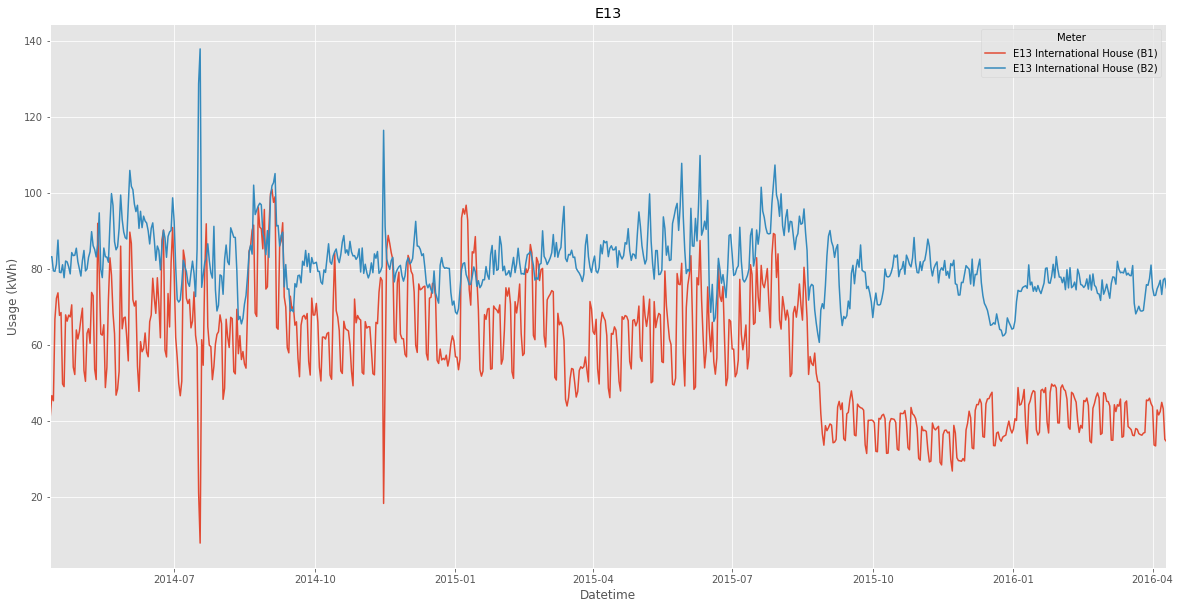

In [61]:
single_building_meters_overlay('E13')

## Robie House

In [62]:
anomalies('E01 Robie House (B2)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



Percent Difference
2015-03-02           13.431308
2015-03-14           14.217076
2015-03-15           14.589861
2015-03-26           16.454381
2015-04-10           13.113434
2015-04-24           16.039166
2015-05-01           17.773413
2015-06-13           17.014097
2015-06-16           14.360365
2015-06-18           12.985920
2015-08-20           13.324447
2015-09-04           26.716316
2015-09-05           14.991498
2015-11-05           22.321671
2015-12-10           14.095280
2015-12-14           19.098194
2016-03-31           13.681778
2016-04-01           24.185152

In [65]:
compare_normal_usage('E01 Robie House (B2)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



## Press Building

In [32]:
compare_normal_usage('F12 Press Building (B1)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [31]:
anomalies('F12 Press Building (B1)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



Percent Difference
2015-01-07           14.417065
2015-01-08           14.229384
2015-01-09           15.797089
2015-01-10           14.867032
2015-01-11           28.267490
2015-01-15           16.925094
2015-01-29           13.224709
2015-01-31           17.688163
2015-02-07           13.122441
2015-02-11           12.239955
2015-03-03           13.017770
2015-03-07           20.284651
2015-03-10           13.836897
2015-03-11           15.294622
2015-03-13           22.142467
2015-03-17           12.359868
2015-03-21           20.892948
2015-03-22           24.735239
2015-03-24           18.983969
2015-03-25           17.999404
2015-03-26           21.452265
2015-03-28           13.136980
2015-03-29           29.978823
2015-04-04           16.389987
2015-04-09           12.576417
2015-05-07           16.135881
2015-05-08           23.880009
2015-07-25           19.536499
2015-08-15           12.078429

## BSLC

/usr/local/conda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


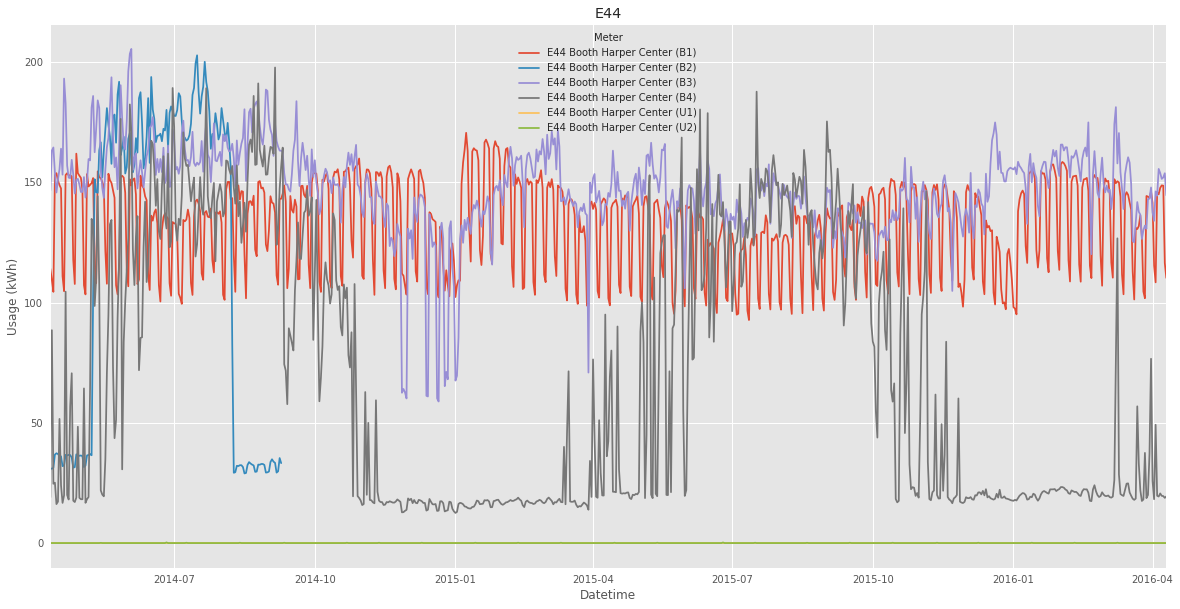

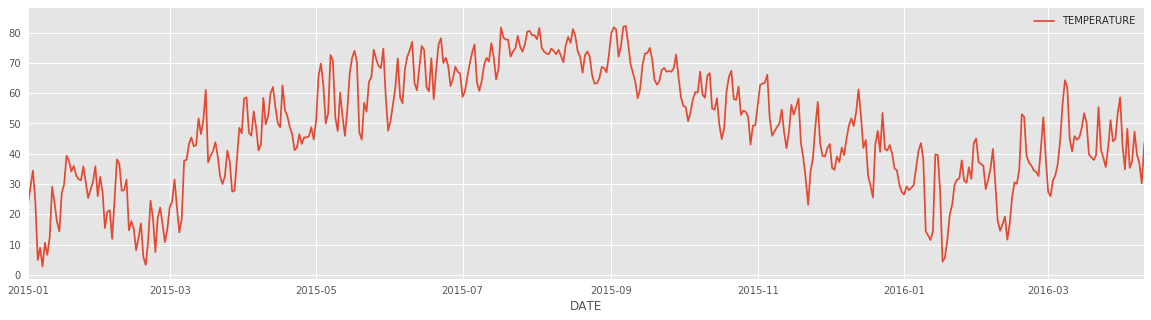

In [41]:
single_building_meters_overlay('E44')
daily_temperature.plot(figsize = (20,5), xlim=(pd.to_datetime('2015-01-01').date(), pd.to_datetime('2016-04-10')))

### B4

In [30]:
compare_normal_usage('E44 Booth Harper Center (B4)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [29]:
percent_diff_lst('E44 Booth Harper Center (B4)').iplot(kind='scatter')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning:


.ix is deprecated. Please use
.loc for label

In [139]:
anomalies('E44 Booth Harper Center (B4)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



Percent Difference
2015-03-13           12.032385
2015-03-15           37.078250
2015-03-30           19.642777
2015-04-06           18.565144
2015-04-10           40.121164
2015-04-17           21.413230
2015-04-18           19.005074
2015-05-06           41.256766
2015-05-08           15.340125
2015-05-11           13.882821
2015-05-14           82.938212
2015-05-21           54.258652
2015-06-03           18.836768
2015-06-06           16.470348
2015-06-10           21.806646
2015-06-15           13.423115
2015-06-26           12.838538
2015-10-09           17.708653
2015-10-19           13.357952
2015-10-23           23.585719
2015-11-01           22.339156
2015-11-05           21.306593
2015-11-06           27.424626
2015-11-11           32.624970
2015-11-18           38.200179
2015-12-26           12.795679
2016-01-18           14.339744
2016-01-20           15.667962
2016-01-21           19.497851
2016-01-23           12.275933
2016-01-24           14.592660
2016-01-26           17.534961
2016-01-27           12.888488
2016-02-02           15.098533
2016-02-03           12.274350
2016-02-04           12.557424
2016-02-06           14.216351
2016-02-09           20.946238
2016-02-10           16.426151
2016-03-10           31.265233
2016-03-22           14.822343
2016-03-23           42.976850
2016-03-30           16.949877
2016-04-01           22.411497
2016-04-02           12.309342
2016-04-03           44.585215
2016-04-09           14.167350

In [194]:
large_anomalies('E44 Booth Harper Center (B4)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



Percent Difference
2015-05-14           61.799877
2016-03-23           61.973947

In [195]:
anomaly_groups('E44 Booth Harper Center (B4)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



array([datetime.date(2015, 3, 13), datetime.date(2015, 3, 15),
       datetime.date(2015, 3, 30), datetime.date(2015, 4, 1),
       datetime.date(2015, 4, 5), datetime.date(2015, 4, 6),
       datetime.date(2015, 4, 9), datetime.date(2015, 4, 10),
       datetime.date(2015, 4, 11), datetime.date(2015, 4, 17),
       datetime.date(2015, 5, 6), datetime.date(2015, 5, 8),
       datetime.date(2015, 5, 11), datetime.date(2015, 5, 14),
       datetime.date(2015, 6, 2), datetime.date(2015, 6, 3),
       datetime.date(2015, 6, 6), datetime.date(2015, 6, 10),
       datetime.date(2015, 6, 15), datetime.date(2015, 6, 26),
       datetime.date(2015, 10, 3), datetime.date(2015, 10, 5),
       datetime.date(2015, 10, 6), datetime.date(2015, 10, 7),
       datetime.date(2015, 11, 1), datetime.date(2015, 11, 5),
       datetime.date(2015, 11, 6), datetime.date(2015, 11, 11),
       datetime.date(2015, 11, 18), datetime.date(2016, 1, 9),
       datetime.date(2016, 1, 18), datetime.date(2016, 1, 19),


### B3

In [196]:
anomalies('E44 Booth Harper Center (B3)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



Percent Difference
2015-03-07           21.746651
2015-03-09           15.508096
2015-10-22           15.053946
2015-12-17           12.133339
2015-12-18           21.014550
2015-12-20           30.454353
2015-12-21           25.371986
2015-12-22           13.697093
2015-12-24           13.844172
2015-12-25           13.745502
2016-01-01           20.972740
2016-01-04           12.639878
2016-01-09           18.824651
2016-03-10           14.030918
2016-04-02           14.153700

In [197]:
large_anomalies('E44 Booth Harper Center (B4)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



Percent Difference
2015-05-14           61.799877
2016-03-23           61.973947

In [198]:
anomaly_groups('E44 Booth Harper Center (B4)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



array([datetime.date(2015, 3, 13), datetime.date(2015, 3, 15),
       datetime.date(2015, 3, 30), datetime.date(2015, 4, 1),
       datetime.date(2015, 4, 5), datetime.date(2015, 4, 6),
       datetime.date(2015, 4, 9), datetime.date(2015, 4, 10),
       datetime.date(2015, 4, 11), datetime.date(2015, 4, 17),
       datetime.date(2015, 5, 6), datetime.date(2015, 5, 8),
       datetime.date(2015, 5, 11), datetime.date(2015, 5, 14),
       datetime.date(2015, 6, 2), datetime.date(2015, 6, 3),
       datetime.date(2015, 6, 6), datetime.date(2015, 6, 10),
       datetime.date(2015, 6, 15), datetime.date(2015, 6, 26),
       datetime.date(2015, 10, 3), datetime.date(2015, 10, 5),
       datetime.date(2015, 10, 6), datetime.date(2015, 10, 7),
       datetime.date(2015, 11, 1), datetime.date(2015, 11, 5),
       datetime.date(2015, 11, 6), datetime.date(2015, 11, 11),
       datetime.date(2015, 11, 18), datetime.date(2016, 1, 9),
       datetime.date(2016, 1, 18), datetime.date(2016, 1, 19),


In [191]:
percent_diff_lst('E44 Booth Harper Center (B4)').iplot()

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



## GCIS

In [190]:
percent_diff_lst('A86 GCIS (B10)').iplot()

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [201]:
compare_normal_usage('A86 GCIS (B10)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



## Jones

In [208]:
compare_normal_usage('D19 Jones Laboratory (B2)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [213]:
anomalies('D19 Jones Laboratory (B2)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



Percent Difference
2015-04-09           16.055066
2015-07-27           12.839222
2015-08-15           14.416781
2015-08-16           16.591725
2015-09-08           14.612698
2015-09-27           12.921525
2015-09-28           16.203668
2016-02-21           34.724758
2016-02-22           24.702507
2016-02-23           30.223135
2016-03-09           12.147631

In [526]:
pd.rolling_mean(electric[electric['Meter'].isin(['E44 Booth Harper Center (B3)'])].Usage, 3).iplot()

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()



In [515]:
electric_day.ix['E44 Booth Harper Center (B3)'].iplot()